# **Predict skin diseases project**

****

<h1 style="color: blue;">Name</h1>

**LEE SANGYUN**

****

<h1 style="color: blue;">Addmin Number</h1>

**X230039**

****

<h1 style="color: blue;">Presentation video link</h1>

<https://drive.google.com/file/d/1I1TNffskbfAw_j7mnNe4MIO27o_YipPW/view?usp=drive_link>

****

<h1 style="color: blue;">Project Objectives & Decision</h1>

<h2 style="color: green;">Project Objectives</h2>

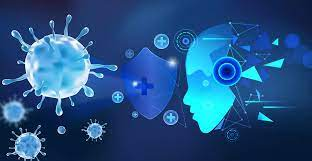

**The AI model I thought of is the "Diagnosis of Skin Diseases." As the air quality is worse and the environment is worse than before, people have more frequent skin diseases. The more you respond to skin diseases in the early stages, the more you can prevent infections and cure them faster. But most people don't have the accuracy to distinguish skin diseases. They often neglect it without knowing whether it is a simple acne or a serious disease. Even with skin cancer, people think of this as a skin mole. These models initially help patients diagnose skin diseases. We wanted to help people improve their skin diseases by creating a model that determines what skin diseases it is. Learn the model by learning the skin disease data. Users can find out what skin diseases they have by taking pictures of their skin diseases and uploading them. Developing such a model will greatly help people respond to skin diseases early. It will also help improve medical diagnosis.**

<h2 style="color: green;">Decision</h2>

**We will develop a model and finally tell you what considerations we have to make of it. First of all, there are four major considerations. Here are the four.**

+ **Merge with diagnostic services:** Doctors are tired of distinguishing many skin diseases one by one. If doctors judge the classified skin diseases first based on pictures of the skin diseases classified through AI, it will be of great help in classifying them. It can speed up diagnosis and reduce fatigue in diagnosing diseases.
<br></br>

+ **Discovery of early patients:** It helps people with suspected skin diseases easily take pictures of skin diseases through camera photos and send them to models to distinguish whether they are skin diseases or not, so that they can go to the hospital early for treatment. This can prevent infection in many people and speed up their recovery by detecting the disease earlier.
<br></br>


+ **AI Ethical Considerations:** Since it is a model that judges a person's body, experiencing certain errors or generalization error can lead to a big accident. Therefore, the dependence of this model should be limited and must be used with professionals.
<br></br>


+ **Data Accumulation:** Data from new patients used in hospitals can be loaded and used for learning. This accumulation of data can increase accuracy in multiple diseases. This will continue to benefit healthcare in the future.

****

<h1 style="color: blue;">Contents</h1>

<a id='table_of_contents'></a>

1. ## [Import libraries](#imports)

2. ## [Data load and visualization](#visualization)

3. ## [Data cleaning and preparation](#cleaning)

4. ## [Custom dataset & Data transform](#transform)

5. ## [Model training](#training)

6. ## [Evaluation & Tuning](#tuning)

7. ## [Model test](#testing)

<h1 style="color: blue;">1. Import libraries</h1> <a id="imports"></a>

[Back to top](#table_of_contents)

In [30]:
# Libraries to help with reading and manipulating data
import os
import glob
import shutil
import random
import hashlib
import pandas as pd

# Libraries to help with data visualization
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# Libraries to ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Libraries to build deep learning model
import torch
import torch.nn as nn
import albumentations as A

from tqdm import tqdm
from torch.optim import AdamW
from lion_pytorch import Lion
from torch.utils.data import Dataset
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from albumentations.pytorch import ToTensorV2

# Libraries to import deep learning models
from torchvision.models.vgg import vgg11
from torchvision.models.resnet import resnet50
from torchvision.models.mobilenetv2 import mobilenet_v2
from torchvision.models.efficientnet import efficientnet_v2_s

<h1 style="color: blue;">2. Data load and visualization</h1> <a id="visualization"></a>

[Back to top](#table_of_contents)

<h2 style="color: green;">Description of the data</h2>

My dataset is divided based on different skin disease names. Each folder name is the name of the skin disease and also the label of the data. There are 6 types of labels in total. Each label contains an average of about 80 image data.

1. Chickenpox
2. Cowpox
3. Healthy
4. HFMD
5. Measles
6. Monkeypox

<h2 style="color: green;">Visualize image data</h2>

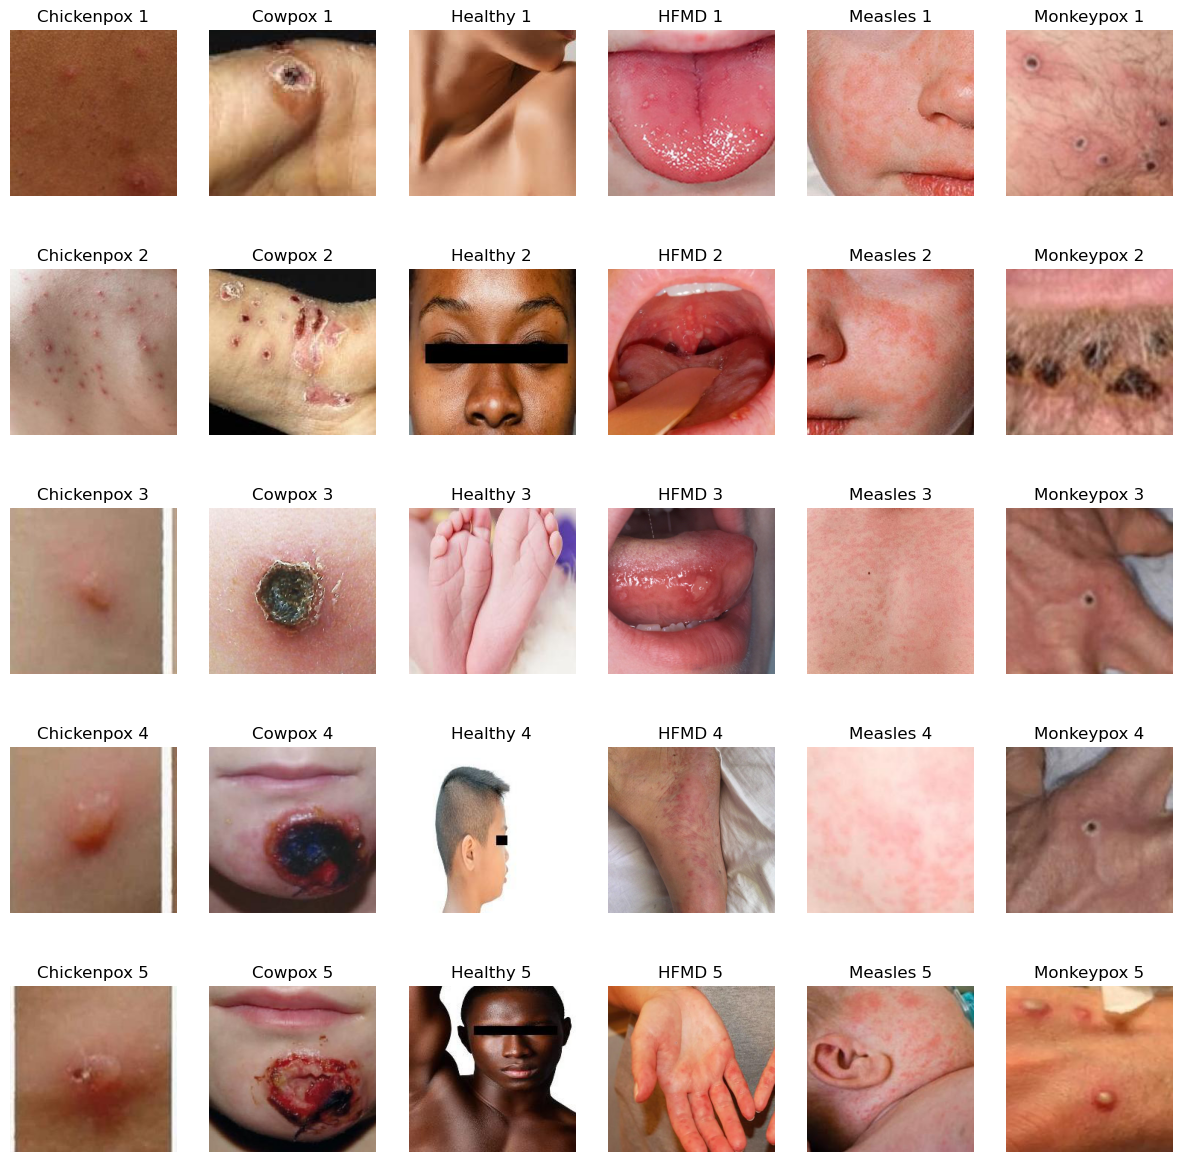

In [2]:
org_data_folder_path = "./skindisease_org_dataset"
label_names = ["Chickenpox", "Cowpox", "Healthy", "HFMD", "Measles", "Monkeypox"]

# Visualize top 5 images for each label
fig, axs = plt.subplots(nrows=5, ncols=len(label_names), figsize=(15, 15))

# Setting labels for each column
for i, label in enumerate(label_names):
    axs[0, i].set_title(label)
    label_path = os.path.join(org_data_folder_path, label)
    
    # Check if the label directory exists
    if os.path.exists(label_path):
        
        # Importing a list of files within a label folder
        files = sorted(os.listdir(label_path))
        
        # Visualize only the top 5 images, excluding non-image files
        image_files = [file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
        for j in range(min(5, len(image_files))):
            file_name = image_files[j]
            file_path = os.path.join(label_path, file_name)
            
            # Loading and Visualizing Images
            img = Image.open(file_path)
            axs[j, i].imshow(img)
            axs[j, i].set_title(f"{os.path.basename(label_path)} {j+1}")
            axs[j, i].axis('off')
    else:
        print(f"Label '{label}' doesn't exist.")
        
plt.show()

<h1 style="color: blue;">3. Data cleaning and preparation</h1> <a id="cleaning"></a>

[Back to top](#table_of_contents)

Before learning the model, data cleaning is essential. In the previous visualization process, we confirmed that the duplicated data was in the dataset. Unnecessary data, error data, and data that cause imbalance need to be removed. The process of deleting them must be implemented in order for the model to learn model accurately. Because model learn the features based on the data.

<h2 style="color: green;">Remove duplicate image data</h2>

First, data cleaning is required before dividing data. This makes learning more accurate and helps the model avoid overfitting. The code below is to delete duplicate image data. By hashing the image, an image with the same hash value is deleted because it is duplicate data.

In [160]:
# Specify the root folder containing label folders
root_folder = './skindisease_org_dataset'
label_names = ["Chickenpox", "Cowpox", "Healthy", "HFMD", "Measles", "Monkeypox"]

def image_hash(file_path):
    with open(file_path, "rb") as f:
        image_data = f.read()
        return hashlib.md5(image_data).hexdigest()

# Duplicate check function for a specific label
def find_and_remove_duplicate_images_for_label(label_folder):
    image_hashes = {}
    duplicate_count = 0

    for root, _, files in os.walk(label_folder):
        for filename in files:
            file_path = os.path.join(root, filename)
            if os.path.isfile(file_path):
                # Calculates the hash value of the image file
                img_hash = image_hash(file_path)

                # Delete an image that already has a hash
                if img_hash in image_hashes:
                    # print(f"Duplicated image in {label_folder}: {file_path}")
                    os.remove(file_path)
                    duplicate_count += 1
                # Save -> key: image hash value: file path
                else:
                    image_hashes[img_hash] = file_path

    print(f"Remove total {duplicate_count} duplicate images in {label_folder}")

# Iterate over label folders
for label_name in label_names:
    label_folder = os.path.join(root_folder, label_name)
    
    # Check if the label folder exists
    if os.path.exists(label_folder):
        find_and_remove_duplicate_images_for_label(label_folder)
    else:
        print(f"Label folder '{label_name}' doesn't exist.")


Remove total 2 duplicate images in ./skindisease_org_dataset/Chickenpox
Remove total 0 duplicate images in ./skindisease_org_dataset/Cowpox
Remove total 0 duplicate images in ./skindisease_org_dataset/Healthy
Remove total 0 duplicate images in ./skindisease_org_dataset/HFMD
Remove total 0 duplicate images in ./skindisease_org_dataset/Measles
Remove total 0 duplicate images in ./skindisease_org_dataset/Monkeypox


<h2 style="color: green;">Split orginal dataset</h2>

The original data does not have data split. We need to split original dataset before learning the model. We need to separate the original data into train, test, and valid datasets. 

+ **Train Data:**

Dataset used by the model to learn characteristics of skin diseases.

+ **Validation Data:**

Dataset used when you want to check your learning status while learning.

+ **Test Data:**

This data is a dataset that is excluded from learning. The dataset used to evaluate the performance of the model after completing the learning with the training dataset.

In [18]:
org_data_folder_path = "./skindisease_org_dataset"

dataset_folder_path = "./skindisease_split_dataset"

#train or val folder path
train_folder_path = os.path.join(dataset_folder_path, "train")
val_folder_path = os.path.join(dataset_folder_path, "valid")
test_folder_path = os.path.join(dataset_folder_path, "test")


#train, val, test folder create
os.makedirs(train_folder_path, exist_ok=True)
os.makedirs(val_folder_path, exist_ok=True)
os.makedirs(test_folder_path, exist_ok=True)

In [31]:
subdirectorys = os.listdir(org_data_folder_path)

for subdirectory in subdirectorys :
    org_folder_full_path = os.path.join(org_data_folder_path, subdirectory)
    
    
    
    # Skip if it's not a directory or DS_Store(mac os only)
    if not os.path.isdir(org_folder_full_path) or subdirectory == ".DS_Store":
        continue
    
    images = os.listdir(org_folder_full_path)
    random.shuffle(images)


    #label folder path
    train_label_folder_path = os.path.join(train_folder_path, subdirectory)
    val_label_folder_path = os.path.join(val_folder_path, subdirectory)
    test_label_folder_path = os.path.join(test_folder_path, subdirectory)
    
    
    os.makedirs(train_label_folder_path, exist_ok=True)
    os.makedirs(val_label_folder_path, exist_ok=True)
    os.makedirs(test_label_folder_path, exist_ok=True)
    
    
    
    #train_split_index는 80% point, val_split_index는 90% point. 
    # Split the images into train, val, test sets
    train_split_index = int(len(images) * 0.8)
    val_split_index = int(len(images) * 0.9) # ->Devide in train, val, test

    
    
    # Move images to the train folder
    for image in images[:train_split_index]:
        src_path = os.path.join(org_folder_full_path, image)
        dst_path = os.path.join(train_label_folder_path, image)
        shutil.copyfile(src_path, dst_path)

    # ->Devide in train, val, test
    # Move images to the validation folder
    for image in images[train_split_index:val_split_index]:
        src_path = os.path.join(org_folder_full_path, image)
        dst_path = os.path.join(val_label_folder_path, image)
        shutil.copyfile(src_path, dst_path)

    # Move images to the test folder
    for image in images[val_split_index:]:
        src_path = os.path.join(org_folder_full_path, image)
        dst_path = os.path.join(test_label_folder_path, image)
        shutil.copyfile(src_path, dst_path)

<h1 style="color: blue;">4. Custom dataset & Data transform</h1> <a id="transform"></a>

[Back to top](#table_of_contents)

A very important process is involved in the custom dataset class. After completing the data cleaning process, read the data and transform it. In addition, image data is read as data in Numpy format using the cv2 library. The read Numpy format image data and labels are declared as numbers and paired. In this way, it is a class that changes the dataset into a format suitable for model learning.

Labels were directly saved in dictionary form from 0 to 5. This is because model learning should be labeled in integer form rather than str form.
- **Chickenpox :** 0
- **Cowpox :** 1 
- **Healthy :** 2 
- **HFMD :** 3
- **Measles :** 4
- **Monkeypox :** 5

I am going to explain the image transformation in detail. It is supposed to use the cv2 library to read the image data in numpy format and then apply the transform that was handed over as a parameter. The transformation is made as follows.

<br></br>
```python
A.Resize(width=224,height=224),
A.VerticalFlip(p=0.5),
A.HorizontalFlip(p=0.5),
A.RandomRotate90(p=0.3),
A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
ToTensorV2()
```
<br></br>

Resize: Change the image size by the corresponding factor value.

Vertical Flip: Reverse vertically with 50% probability.

Horizontal Flip: Reverse horizontally with 50% probability.

Random Rotate 90: Rotate at 90 degrees with 30 percent probability.

Normalize: Standardize data values. Average 0.5 and variance 0.2.

ToTensorV2: Tensorsize the Numpy format.

<h2 style="color: green;">Build customdataset</h2>

In [32]:
class CustomDataset(Dataset) :
    
    def __init__(self, data_dir, transform=None) :
        
        self.data_dir = glob.glob(os.path.join(data_dir, "*", "*.jpg"))
        self.transform = transform
        self.label_dict = {'Chickenpox' : 0, 'Cowpox' : 1, 'Healthy' : 2, 'HFMD' : 3,
                           'Measles' : 4, 'Monkeypox' : 5
                        }
        
    def __getitem__(self, item):
        
        image_filepath = self.data_dir[item]
        img = cv2.imread(image_filepath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        label = os.path.basename(os.path.dirname(image_filepath))
        label_idx = self.label_dict[label]

        if self.transform is not None :
            image = self.transform(image=img)['image']

        return image, label_idx
        
    def __len__(self) :
        
        return len(self.data_dir)

<h1 style="color: blue;">5. Model training</h1> <a id="training"></a>

[Back to top](#table_of_contents)

It consists of two hyper parameters required hyper parameters and model learning classes. Classifier_SkinDiseases learns features by using deep learning named CNN with the previous dataset. Args Class is easily managed by creating multiple variables required to model.

I used 4models to decide the model which is the best.

+ **vgg11_bn**
+ **resnet50**
+ **mobilenet_v2**
+ **efficientnet_v2_s**

These are representative CNN models. They are often used for image classification. We will try them and select the best model based on the loss values and accuracy calculated using Valid dataet.

<h2 style="color: green;"> Define classifier skin diseases model class</h2>

In addition, to explain the overall code, this process is the part that defines the learning model. The class name is Classifier_SkinDiseases, and within this class, it consists of a class variable generator and five functions.

+ **def run(self, args):** Model's declaration is made first. It fetches a model with a pre-adjusted hyperparameter and adjusts the final number of outputs according to our data label(total: 6). In addition, this part is the part where the model uses a certain DataLoader library to divide the data into a certain batch size and send it before model learns the features.
<br></br>

+ **def train(self, train_loader, val_loader, epochs, optimizer, criterion, start_epoch=0):** Here, feature learning and feature verification are performed. As the learning proceeds by a predetermined epoch, the weight and bias are gradually adjusted by the optimizer. It can become a model with high accuracy only through this process. In addition, as learning proceeds, the corresponding weights and bias are stored in the pt file. This can be done by fetching the pt file that used in the model test process. It is also used when you want to continue learning later.
<br></br>

+ **def save_results_to_csv(self):** Record loss and accuracy in csv file.
<br></br>

+ **def plot_loss(self):** Visualize losses each epoch
<br></br>

+ **def plot_accuracy(self):** Visualize accuracy each epoch

In [35]:
# Class that classify 6 labels of skin diseases
class Classifier_SkinDiseases :
    
    def __init__(self) :
        
        # Use mac os GPU
        # If you don't have GPU, you can use CPU by chaning "mps" to "cpu"
        self.device = torch.device("mps")
        self.model = None
        self.train_losses = []
        self.valid_losses = []
        self.train_accs = []
        self.valid_accs = []
        
        

    # Training with clean data
    def train(self, train_loader, val_loader, epochs, optimizer, criterion, start_epoch=0) :
        best_val_acc = 0.0
        print("Training start...")
        
        for epoch in range (start_epoch, epochs) :
            train_loss = 0.0
            val_loss = 0.0
            train_acc = 0.0
            val_acc = 0.0
            
            self.model.train()
            train_loader_iter = tqdm(train_loader, desc=(f"Epoch : {epoch + 1}/{epochs}"), leave=False)
            
            for index, (data, target) in enumerate(train_loader_iter) :
                data, target = data.float().to(self.device), target.to(self.device)
                
                optimizer.zero_grad()
                outputs = self.model(data)
                loss = criterion(outputs, target)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                
                _, pred = torch.max(outputs, 1)
                train_acc += (pred == target).sum().item()
                
                train_loader_iter.set_postfix({"Loss" : loss.item()})
                
                
            train_loss /=len(train_loader)
            train_acc = train_acc / len(train_loader.dataset)
            
            # Validate each epoch accuracy
            self.model.eval()
            with torch.no_grad() :
                
                for data, target in val_loader :
                    
                    data, target = data.float().to(self.device), target.to(self.device)
                    output = self.model(data)
                    pred = output.argmax(dim=1, keepdim=True)
                    val_acc += pred.eq(target.view_as(pred)).sum().item()
                    val_loss += criterion(output, target).item()
                    
                val_loss /= len(val_loader)
                val_acc = val_acc / len(val_loader.dataset)
                
                self.train_losses.append(train_loss)
                self.train_accs.append(train_acc)
                self.valid_losses.append(val_loss)
                self.valid_accs.append(val_acc)
                
                print(f"Epoch [{epoch + 1}/{epochs}], Train loss: {train_loss:.4f}, "
                  f"Val loss: {val_loss:.4f}, Train ACC: {train_acc:.4f}, Val ACC: {val_acc:.4f}")
                
                if val_acc > best_val_acc :
                    torch.save(self.model.state_dict(), "./weight/model_best.pt")
                    best_val_acc = val_acc
                    
                #save the model state and optimizer state after each epoch
                torch.save({
                    "epoch" : epoch + 1,
                    "model_state_dict" : self.model.state_dict(),
                    "optimizer_state_dict" : optimizer.state_dict(),
                    "train_losses" : self.train_losses,
                    "train_accs" : self.train_accs,
                    "val_losses" : self.valid_losses,
                    "val_accs" : self.valid_accs,
                }, args.checkpoint_path)
                
                
                
        self.save_results_to_csv()
        self.plot_loss()
        self.plot_accuracy()

        
    # Save loss, acc to csv file
    def save_results_to_csv(self):
        df = pd.DataFrame({
            'Tr ain Loss' : self.train_losses,
            'Train ACC' : self.train_accs,
            'Validation Loss' : self.valid_losses,
            'Validation ACC' : self.valid_accs
        })
        df.to_csv('./visualization/train_val_result.csv', index=False)

    # Visualize loss history for each epoch
    def plot_loss(self):
        plt.figure()
        plt.plot(self.train_losses, label="Train loss")
        plt.plot(self.valid_losses, label="val loss")
        plt.xlabel("Epoch")
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig("./visualization/loss_plot.jpg")

    # Visualize accuracy history for each epoch
    def plot_accuracy(self):
        plt.figure()
        plt.plot(self.train_accs, label="Train Accuracy")
        plt.plot(self.valid_accs, label="Valid Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig("./visualization/accuracy_plot.jpg")


    # Run main code
    def run(self, args):
        # Initialize and assign the model
        self.model = vgg11(weights=True)
        num_feature = self.model.classifier[6].in_features
        self.model.classifier[6] = nn.Linear(num_feature, out_features=6)
        self.model.to(self.device)


        train_transforms = A.Compose([
            A.Resize(width=224,height=224),
            A.VerticalFlip(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.RandomRotate90(p=0.3),
            A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
            ToTensorV2()
        ])

        val_transforms = A.Compose([
            A.Resize(width=224, height=224),
            A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),    
            ToTensorV2()
        ])

        # dataset and dataloader
        train_dataset = CustomDataset(args.train_dir, transform=train_transforms)
        val_dataset = CustomDataset(args.val_dir, transform=val_transforms)

        train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=True)

        epochs = args.epochs
        criterion = CrossEntropyLoss().to(self.device)
        optimizer = AdamW(self.model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
        start_epoch = 0

        
        
        # If training is stopped, resume training by using this function
        if args.resume_training :
            checkpoint = torch.load(args.checkpoint_path)
            self.model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.train_losses = checkpoint['train_losses']
            self.train_accs = checkpoint['train_accs']
            self.valid_losses = checkpoint['val_losses']
            self.valid_accs = checkpoint['val_accs']
            start_epoch = checkpoint['epoch']

            
        # Start training with deep learning model
        self. train(train_loader, val_loader, epochs, optimizer, criterion, start_epoch=start_epoch)                 
                

<h2 style="color: green;">Define Hyperparameter and run Classifier_SkinDiseases class</h2>

This is where the hyperparameters needed to learn the model are determined. The hyperparameters used are as follows.

+ **epochs=20:** Epoch is the number of times you learn.
<br></br>

+ **batch_size=4:** Batch size is an option that determines how much data you want to divide.
<br></br>

+ **lr=0.001:** Learning rate determines how much optimizer is applied at once.
<br></br>

+ **weight_decay=1e-2:** This is an option to limit too much weight when modifying the weight in the optimizer.
<br></br>

+ **resume_training=True:** If you want to continue learning, set this option "True".


Training start...


Epoch [1/20], Train loss: 1.9110, Val loss: 1.6310, Train ACC: 0.3111, Val ACC: 0.3841


Epoch [2/20], Train loss: 1.6520, Val loss: 1.6479, Train ACC: 0.3750, Val ACC: 0.3841


Epoch [3/20], Train loss: 1.6814, Val loss: 1.5909, Train ACC: 0.3500, Val ACC: 0.3841


Epoch [4/20], Train loss: 1.6414, Val loss: 1.6900, Train ACC: 0.3667, Val ACC: 0.3841


Epoch [5/20], Train loss: 1.6588, Val loss: 1.6442, Train ACC: 0.3486, Val ACC: 0.3623


Epoch [6/20], Train loss: 1.6421, Val loss: 1.6409, Train ACC: 0.3750, Val ACC: 0.3841


Epoch [7/20], Train loss: 1.6267, Val loss: 1.5581, Train ACC: 0.3736, Val ACC: 0.3913


Epoch [8/20], Train loss: 1.6024, Val loss: 1.6204, Train ACC: 0.4139, Val ACC: 0.3841


Epoch [9/20], Train loss: 1.5453, Val loss: 1.4846, Train ACC: 0.4111, Val ACC: 0.4565


Epoch [10/20], Train loss: 1.4794, Val loss: 1.4538, Train ACC: 0.4431, Val ACC: 0.4638


Epoch [11/20], Train loss: 1.4974, Val loss: 1.4352, Train ACC: 0.4444, Val ACC: 0.4420


Epoch [12/20], Train loss: 1.4365, Val loss: 1.3569, Train ACC: 0.4722, Val ACC: 0.4928


Epoch [13/20], Train loss: 1.4350, Val loss: 1.4602, Train ACC: 0.4958, Val ACC: 0.4493


Epoch [14/20], Train loss: 1.3839, Val loss: 1.4875, Train ACC: 0.4861, Val ACC: 0.4275


Epoch [15/20], Train loss: 1.4292, Val loss: 1.3862, Train ACC: 0.4917, Val ACC: 0.4928


Epoch [16/20], Train loss: 1.3650, Val loss: 1.4410, Train ACC: 0.4958, Val ACC: 0.4783


Epoch [17/20], Train loss: 1.3273, Val loss: 1.2557, Train ACC: 0.5056, Val ACC: 0.5217


Epoch [18/20], Train loss: 1.3195, Val loss: 1.4858, Train ACC: 0.5472, Val ACC: 0.4565


Epoch [19/20], Train loss: 1.3736, Val loss: 1.3227, Train ACC: 0.5083, Val ACC: 0.5290


Epoch [20/20], Train loss: 1.2810, Val loss: 1.2270, Train ACC: 0.5431, Val ACC: 0.5652


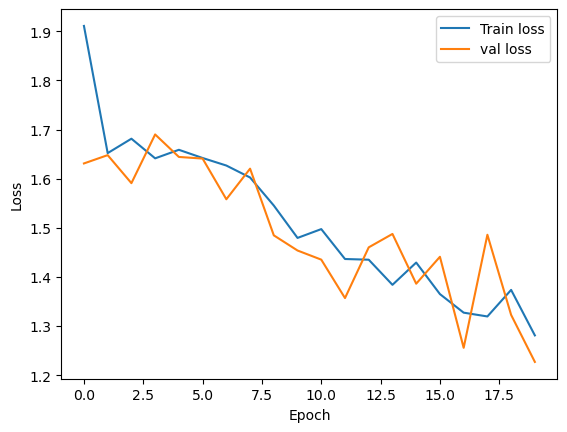

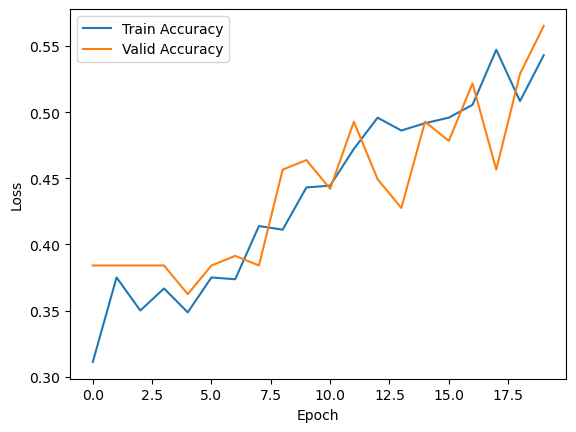

In [37]:
class Args:
    def __init__(self, train_dir, val_dir, epochs, batch_size, lr, weight_decay, resume_training,
                 checkpoint_path, checkpoint_folder_path, visualization_folder_path):
        self.train_dir = train_dir
        self.val_dir = val_dir
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.weight_decay = weight_decay
        self.resume_training = resume_training
        self.checkpoint_path = checkpoint_path
        self.checkpoint_folder_path = checkpoint_folder_path
        self.visualization_folder_path = visualization_folder_path

# Define hyperparmeters
args = Args(
    train_dir="./skindisease_split_dataset/train/",
    val_dir="./skindisease_split_dataset/valid/",
    epochs=20,
    batch_size=32,
    lr=0.001,
    weight_decay=1e-2,
    resume_training=False,
    checkpoint_path="./weight/model_checkpoint.pt",
    checkpoint_folder_path="./weight/",
    visualization_folder_path="./visualization/"
)

# Create weight folder
weight_folder_path = args.checkpoint_folder_path
os.makedirs(weight_folder_path, exist_ok=True)

# Create visualization folder
visualization_folder_path = args.visualization_folder_path
os.makedirs(visualization_folder_path, exist_ok=True)

# Instantiate the classifier and run
classifier = Classifier_SkinDiseases()
classifier.run(args)


<h1 style="color: blue;">6. Evaluation & Tuning</h1> <a id="tuning"></a>

[Back to top](#table_of_contents)

While learning from the previous model, I save loss values and accuracy for each epoch. These values were saved as csv files and image files as functions described above. Looking at the saved image, I can refer to it for evaluating the performance of the model and adjusting the hyperparameters in the future.

<h2 style="color: green;">Evaluate 4 models and select 1 model</h2>

There are 4 models history. In the following code, the results of learning 20 epochs per model were combined and visualized. Looking at the visualization data, the loss values are ideally decreasing as we learn. To evaluate the performance of the model, you should look at the accuracy.

First of all, the efficientnet_v2_s model is the deepest model, so it recorded high accuracy from the beginning. However, after the 18 efork, the performance decreases even in validation and train. This means that it is overfitted. Therefore, I will no longer proceed with learning and will store and use the highest of the results ㅠbetween 0~20.

vgg11, resnet50, and mobilenet_v2 also increase in accuracy as learning progresses. Here, we will adjust the hyperparameters of resnet50 and mobilenet_v2, which recorded more accuracy, in the next tuning process.

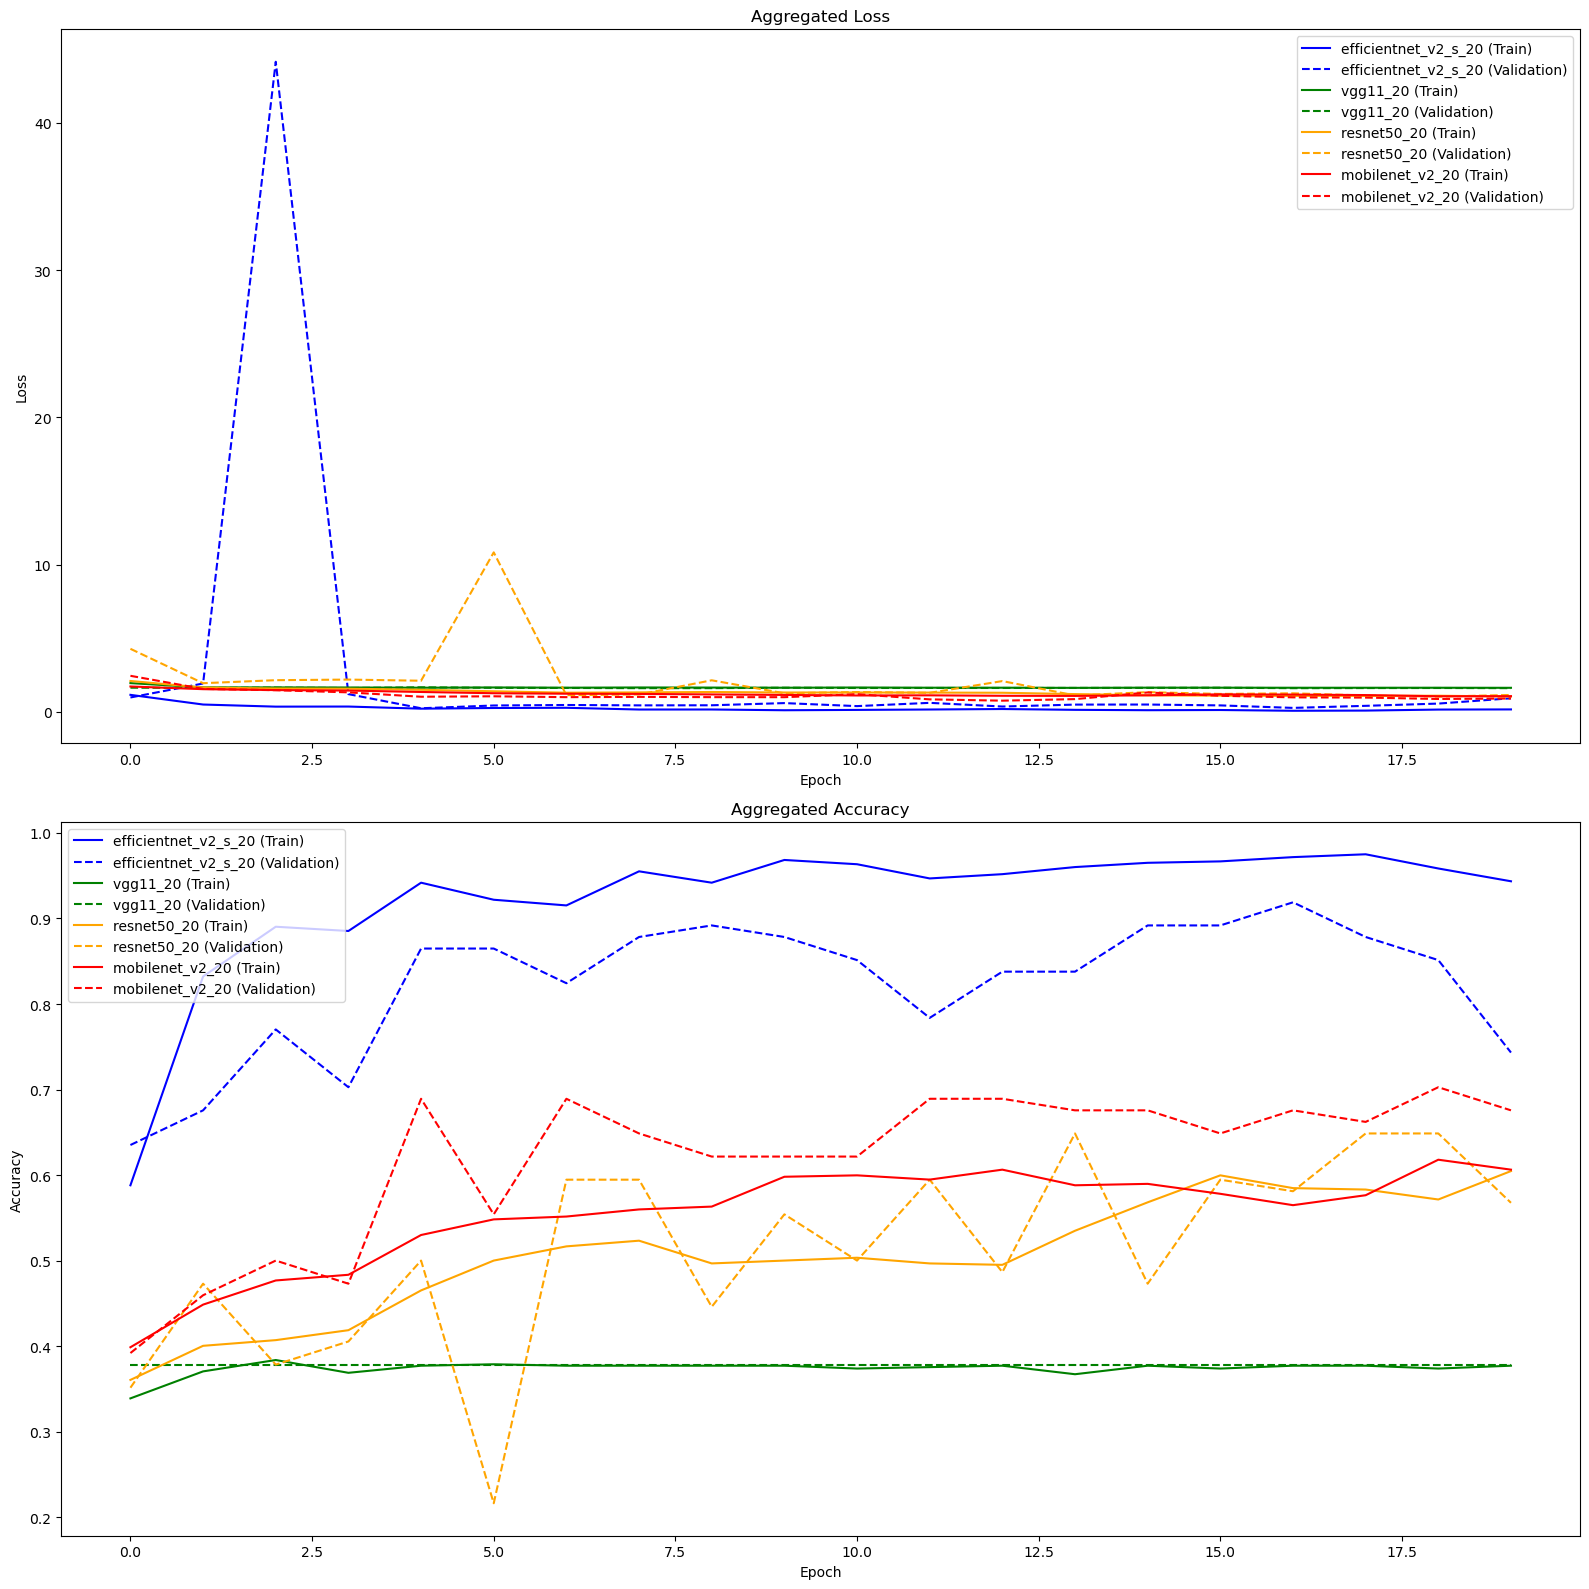

In [64]:
def visualize_multiple_models(directory_list):
    fig, axes = plt.subplots(2, 1, figsize=(16, 16))
    
    # Define a color map for each model
    color_map = {'./efficientnet_v2_s_20/': 'blue', './vgg11_20/': 'green', './resnet50_20/': 'orange', './mobilenet_v2_20/': 'red'}

    all_loss_df = pd.DataFrame()
    all_acc_df = pd.DataFrame()

    for directory in directory_list:
        # Get a list of all CSV files in the directory
        csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')]

        # Extract model name from directory path
        model_name = directory.split('/')[-2]

        for csv_file in csv_files:
            # Load CSV data with comma as separator
            csv_path = os.path.join(directory, csv_file)
            df = pd.read_csv(csv_path, delimiter=',')

            # Aggregate loss and accuracy data for all models
            all_loss_df[f'{model_name} - {csv_file[:-4]} (Train)'] = df['Train Loss']
            all_loss_df[f'{model_name} - {csv_file[:-4]} (Validation)'] = df['Validation Loss']
            
            all_acc_df[f'{model_name} - {csv_file[:-4]} (Train)'] = df['Train ACC']
            all_acc_df[f'{model_name} - {csv_file[:-4]} (Validation)'] = df['Validation ACC']

            # Plotting code for training loss
            axes[0].plot(df.index, df['Train Loss'], label=f'{model_name} (Train)', linestyle='-', color=color_map[directory])

            # Plotting code for validation loss
            axes[0].plot(df.index, df['Validation Loss'], label=f'{model_name} (Validation)', linestyle='dashed', color=color_map[directory])

            # Plotting code for training accuracy
            axes[1].plot(df.index, df['Train ACC'], label=f'{model_name} (Train)', linestyle='-', color=color_map[directory])

            # Plotting code for validation accuracy
            axes[1].plot(df.index, df['Validation ACC'], label=f'{model_name} (Validation)', linestyle='dashed', color=color_map[directory])

    # Set titles and labels for each subplot
    axes[0].set_title('Aggregated Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].set_title('Aggregated Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# Replace 'your_directory_path' with the actual paths where your files are located
directory_list = ['./efficientnet_v2_s_20/', './vgg11_20/', './resnet50_20/', './mobilenet_v2_20/']
visualize_multiple_models(directory_list)


<h2 style="color: green;">Tuning the epoch</h2>

The resnet50 and mobileenet_v2 models were learned with 150, 200 epochs. The accuracy of both models increased. However, in the case of the resnet50, the accuracy is close to 90% in the training data, but the value is low in the validation data. In this case, the accuracy may be low when the actual test is conducted. Mobilnet_v2 also shows accuracy close to 90%, but it is difficult to expect a constant accuracy because the deviation is too severe for each epoch.

Finally, I decided to select efficientnet_v2_s. It showed the highest accuracy, and the deviation was the least for each epoch. Although overfitting occurred in the 20epoch, it does not matter because the model_best.pt file contains the weight and bias of the epoch with the highest accuracy.


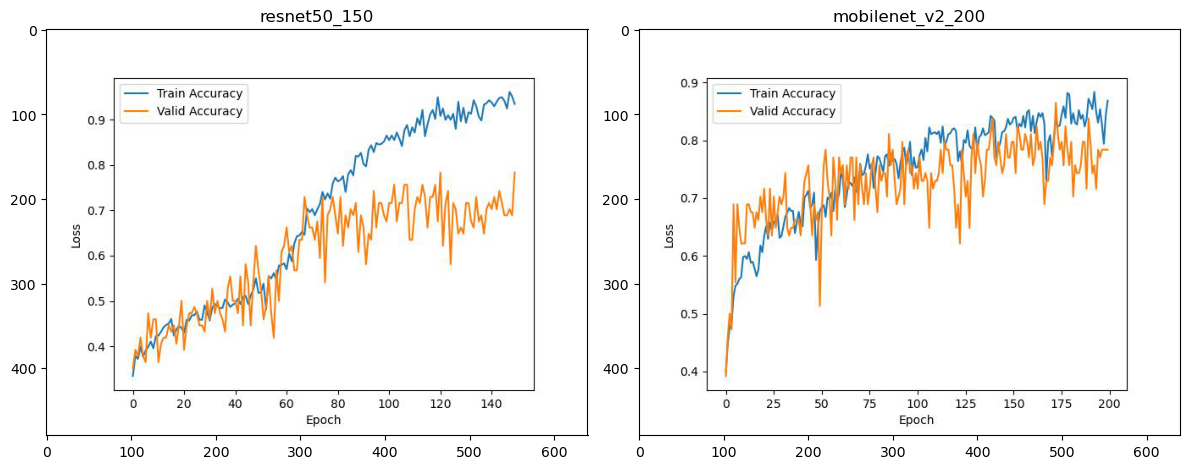

In [66]:
# Set image location
image_paths = ['./resnet50_150/accuracy_plot.jpg', './mobilenet_v2_200/accuracy_plot.jpg']

# Create 1x2 subplot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Visualize the image
for i, ax in enumerate(axes):
    img = Image.open(image_paths[i])
    ax.imshow(img)
    ax.set_title(image_paths[i].split('/')[-2])  # Title name

plt.tight_layout()
plt.show()

<h1 style="color: blue;">7. Model test</h1> <a id="testing"></a>

[Back to top](#table_of_contents)

I test the final model with test data that are not used for training and validation. Testing with new data allows real users to predict accuracy when using the model.

In the case of resnet_50, the accuracy was 80% and in the case of mobilenet_v2, **the last efficient net_v2_s model I chose was 98%.**

In [74]:
# Set the device
device = torch.device("mps") # mac m1 or m2

# model setting
model = efficientnet_v2_s(weights=True)
model.classifier[0] = nn.Dropout(p=0.5, inplace=True)
model.classifier[1] = nn.Linear(1280, out_features=6)
model.to(device)

# model = resnet50(pretrained=True)
# num_features = model.fc.in_features
# model.fc = nn.Linear(num_features, 6)
# model.to(device)

# model = mobilenet_v2(pretrained=True)
# model.classifier[1] = nn.Linear(1280, 6)
# model.to(device)

# model = efficientnet_b0()
# model.classifier[0] = nn.Dropout(p=0.5, inplace=True)
# model.classifier[1] = nn.Linear(1280, out_features=6)
# model.to(device)

# .pt load
model.load_state_dict(torch.load(f="./weight/model_best.pt"))
# print(list(model.parameters()))


test_transforms = A.Compose([
    A.Resize(width=224,height=224),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.3),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
    ToTensorV2()
])

# dataset and dataloader
test_dataset = CustomDataset("./skindisease_split_dataset/test/", transform=test_transforms)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model.to(device)
model.eval()

correct = 0

with torch.no_grad() :
    for data, target in tqdm(test_loader) :
        data, target = data.float().to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

print("test set : Acc {}/{} [{:.0f}]%\n".format(correct, len(test_loader.dataset), 100 * correct / len(test_loader.dataset)))


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.30it/s]

test set : Acc 151/154 [98]%

